# LineModDB

In [117]:
import os
import sys
sys.path.append('..')
sys.path.append('../../')
sys.path.append('../../../')
from glob import glob

from config.config import cfg
from src.utils.base_utils import read_ply_model

In [118]:
import numpy as np
#from plyfile import PlyData

## 3D Plot 用ライブラリをロード

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [120]:
base_dir = cfg.LINEMOD_DIR
object_name = 'ape'

## read_3d_point Test

In [121]:
def read_3d_points(filename):
        with open(filename) as f:
            in_vertex_list = False
            vertices = []
            in_mm = False
            for line in f:
                if in_vertex_list:
                    vertex = line.split()[:3]
                    vertex = np.array([[float(vertex[0])],
                                                          [float(vertex[1])],
                                                          [float(vertex[2])]],
                                                          dtype=np.float32)
                    if in_mm:
                        vertex = vertex / np.float32(10) # mm -> cm
                    vertex = vertex / np.float32(100) # cm -> m
                    vertices.append(vertex)
                    if len(vertices) >= vertex_count:
                        break
                elif line.startswith('element vertex'):
                    vertex_count = int(line.split()[-1])
                elif line.startswith('end_header'):
                    in_vertex_list = True
                elif line.startswith('element face'):
                    in_mm = True
        return vertices

In [122]:
filenames = glob(os.path.join(base_dir, object_name, '*.ply'))
print(filenames)
filename = filenames[0]

vertices = read_3d_points(filename)

print(vertices)


       [-0.0159688]], dtype=float32), array([[-0.0216407],
       [-0.0146209],
       [-0.0164644]], dtype=float32), array([[ 0.00045176],
       [ 0.0395507 ],
       [-0.0410252 ]], dtype=float32), array([[ 0.0188079 ],
       [ 0.0189133 ],
       [-0.06827381]], dtype=float32), array([[-0.0333898 ],
       [-0.0073597 ],
       [-0.00125748]], dtype=float32), array([[-0.0058811 ],
       [-0.00097199],
       [-0.0500007 ]], dtype=float32), array([[ 0.0157192],
       [ 0.0133282],
       [-0.0861312]], dtype=float32), array([[ 0.0169909],
       [ 0.0119787],
       [-0.0857204]], dtype=float32), array([[ 0.0387356],
       [-0.0113963],
       [-0.018281 ]], dtype=float32), array([[ 0.0381139],
       [-0.0125783],
       [-0.0193455]], dtype=float32), array([[ 0.039341 ],
       [ 0.0012703],
       [-0.0363044]], dtype=float32), array([[ 0.0129079 ],
       [-0.021099  ],
       [-0.00146649]], dtype=float32), array([[-0.0173083],
       [-0.0217725],
       [-0.0437112]], dt

## read_pose Test

In [123]:
def read_pose(rot_path: str, tra_path: str) -> np.matrix:
        """オブジェクトの '.rot' ファイル と '.tra' ファイルの情報を読み出し，スケール変換を加えて返す関数

        Args:
            rot_path str: `.rot` ファイルのパス
            tra_path str: `.tra` ファイルのパス

        Returns:
            np.matrix: 姿勢行列
        """
        rot = np.loadtxt(rot_path, skiprows=1)
        tra = np.loadtxt(tra_path, skiprows=1) / 100.
        return np.concatenate([rot, np.reshape(tra, newshape=[3, 1])], axis=-1)

## read_ritation Test

In [124]:
    def read_rotation(filename: str) -> np.matrix:
        """LineMod3Dモデルの回転行列を計算する関数

        Arg:
            filename (str): 単一のLineMod3Dモデルの回転情報が保存された '.rot' ファイルへの絶対パス

        Return:
            R [np.matrix]: 単一のLineMod3Dモデルの(3, 3)回転行列
        """
        with open(filename) as f:
            f.readline()
            R = []
            for line in f:
                R.append(line.split())
            R = np.array(R, dtype=np.float32)
        return R

In [125]:
filenames = glob(os.path.join(base_dir, object_name, 'data', '*.rot'))

R = read_rotation(filenames[0])

print(R)

[[ 0.867359  0.493894 -0.06129 ]
 [-0.377636  0.733345  0.565329]
 [ 0.32416  -0.467198  0.822585]]


In [126]:
def read_transform_dat(dat_path: str) -> np.matrix:
        """
        オリジナルの LineMod データセットから dat ファイルを読み出す関数

        Returns:
            transform_dat(np.matrix): 読み出したデータ
        """
        transform_dat = np.loadtxt(dat_path, skiprows=1)[:, 1]
        transform_dat = np.reshape(transform_dat, newshape=[3, 4])
        return transform_dat

## Translation

In [127]:
def read_translation(filename: str) -> np.matrix:
        """LineMod3Dモデルの並進行列を計算する関数

        Arg:
            filename (str): 単一のLineMod3Dモデルの並進情報が保存された '.tra' ファイルへの絶対パス

        Return:
            T [np.matrix]: 単一のLineMod3Dモデルの(3, 3)並進行列
        """
        with open(filename) as f:
            f.readline()
            T = []
            for line in f:
                T.append([line.split()[0]])
            T = np.array(T, dtype=np.float32)
            T = T / np.float32(100) # cm -> m
        return T

In [128]:
filenames = glob(os.path.join(base_dir, object_name, 'data', '*.tra'))

T = read_translation(filenames[0])

print(T)

[[-0.131321  ]
 [-0.054818  ]
 [ 0.80527997]]


## LineModDBクラス

In [129]:
class LineModDB(object):
    """
    DataLoader for the Linemod dataset

    """
    def __init__(self,
                              linemod_dir: str,
                              obj_name: str = 'all'):
        """
        Initializes a Linemod DataLoader

        Args:
            linemod_dir(str): LineMod データセットのディレクトリパス
            obj_name(str): LineMod データセットに含まれるオブジェクト名
        """

        self.base_dir = linemod_dir
        self.image_shape=(480, 640), # (h, w)
        if obj_name == 'all':
            self.obj_names = cfg.linemod_obj_names
        elif obj_name in cfg.linemod_obj_names:
            self.obj_names = [obj_name]
        else:
            raise ValueError('Invalid object name: {}'.format(obj_name))
        # compute length
        self.lengths = {}
        self.total_length = 0
        for obj_name in self.obj_names:
            length = len(list(filter(lambda x:x.endswith('jpg'), os.listdir(os.path.join(base_dir, obj_name, 'data')))))
            self.lengths[obj_name] = length
            self.total_length += length
        self.model_path = os.path.join(linemod_dir,
                                                                        '{}/mesh.ply'.format(obj_name))
        self.old_model_path = os.path.join(linemod_dir,
                                                                                 '{}/OLDmesh.ply'.format(obj_name))
        self.transform_dat_path = os.path.join(self.base_dir,
                                                                                        '{}/transform.dat'.format(obj_name))


    def load_ply_model(self) -> np.ndarray:
        """
        LineMod データセットから `.ply` ファイルに保存された3dモデルデータをスケール変換を行いつつ読み出すための関数

        Return:
            (np.ndarray): numpy配列に変換した 3D モデル
        """
        if os.path.exists(self.model_path):
            return read_ply_model(self.model_path) / 1000.
        else:
            transform = read_transform_dat(self.transform_dat_path)
            old_model = read_ply_model(self.old_model_path) / 1000.
            old_model = np.dot(old_model, transform[:, :3].T) + transform[:, 3]
            return old_model


    def __len__(self):
        return self.total_length


    def __getitem__(self, idx):
        local_idx = idx
        for obj_name in self.obj_names:
            if local_idx < self.lengths[obj_name]:
                obj_pth = os.path.join(self.base_dir, obj_name)
                dat_dir = os.path.join(obj_pth, 'data')
                # image
                img_pth = os.path.join(dat_dir,
                                                                'color{}.jpg'.format(local_idx))
                img = transforms.ToTensor()(Image.open(img_pth).convert('RGB'))
                pose = read_pose(os.path.join(dat_dir, 'rot{}.rot'.format(local_idx)),
                                                      os.path.join(dat_dir, 'tra{}.tra'.format(local_idx)))

## インスタンス生成

In [130]:
db = LineModDB(linemod_dir = cfg.LINEMOD_DIR,
                                   obj_name=object_name)

## 取得したデータセットの合計を取得

In [131]:
print(db.__len__())

1236


## load_ply_model Test

In [132]:
ply_model = db.load_ply_model()
print('ply_model_type =')
print(type(ply_model))
print('ply_model = ')
print(ply_model)
print('shape =', ply_model.shape)

ply_model_type =
<class 'numpy.ndarray'>
ply_model = 
[[ 0.027601    0.0220686  -0.0377873 ]
 [ 0.0174218  -0.0249059  -0.0168277 ]
 [ 0.0368221  -0.0130557  -0.0120928 ]
 ...
 [ 0.00405309  0.0277681  -0.00469088]
 [ 0.0202621  -0.0220967  -0.0259147 ]
 [ 0.0177486   0.0130133  -0.0842276 ]]
shape = (5841, 3)


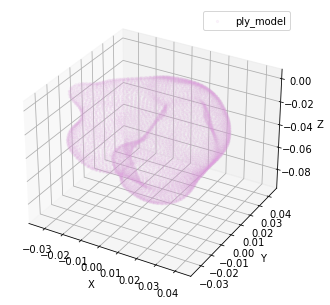

In [133]:
X_ply_model = []
Y_ply_model = []
Z_ply_model = []

for value in ply_model:
    X_ply_model.append(value[0])
    Y_ply_model.append(value[1])
    Z_ply_model.append(value[2])

# グラフの枠を作成
fig = plt.figure()
ax = Axes3D(fig)

# X,Y,Z軸にラベルを設定
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# .scatterで描画
ax.scatter(X_ply_model,
                      Y_ply_model,
                      Z_ply_model,
                      s=5,
                      c="plum",
                      marker="o",
                      alpha=0.1,
                      label="ply_model")

# 凡例を表示          
ax.legend()

# 最後に.show()を書いてグラフ表示
plt.show()

## __getitem__ Test

In [134]:
from PIL import Image
from torchvision import transforms

In [135]:
print(db.__getitem__(idx=2))

None
